In [1]:
import torch
import sys
sys.path.append('../')
from DataType.ElectricField import ElectricField
from LightSource.PlaneWave import PlaneWave
from Props.AngularSpectrum import ASMPropagator as ASM_prop
from Props.RayleighSommerfeld import RSCPropagator as RSC_prop
from Components.Thin_Lens import Thin_LensElement
from Components.Aperture import ApertureElement
from Components.QuantizedDOE import SoftGumbelQuantizedDOELayerv3 as SoftGumbelQuantizedDOELayer
from Components.QuantizedDOE import FullPrecisionDOELayer
from Components.QuantizedDOE import FixDOEElement
from Addons.Field_Crop import Field_Cropper
from utils.units import *
import numpy as np
import scipy.io
import time
import torch.nn as nn

In [2]:
# DOE parameters
epsilon = 1.6**2
tand = 0

wavelength = 633 * nm


input_field_shape = [1024, 1024]
input_dxy = 6.4 * um
doe_shape = [512, 512]
doe_dxy = 12.8 * um

crop_size = 512
#print("The number of wavelengths: " +  str(wavelengths.shape[0]))

# all parameters of DOE optimization
doe_params = {
    'doe_size': doe_shape,
    'doe_dxy' : doe_dxy,
    'doe_level': 2**3,
    'look_up_table': None,
    'num_unit': None,
    'height_constraint_max': 2*um,
    'tolerance': 0,  
    'material': [epsilon, tand]
}

optim_params = {
    'c_s': 100,   # a number to boost the score (higher more robust to gumbel noise)
    'tau_max': 2.5, # maximum value of tau
    'tau_min': 1.5  # minimum value of tau
}

torch.Size([1, 1, 200, 200])


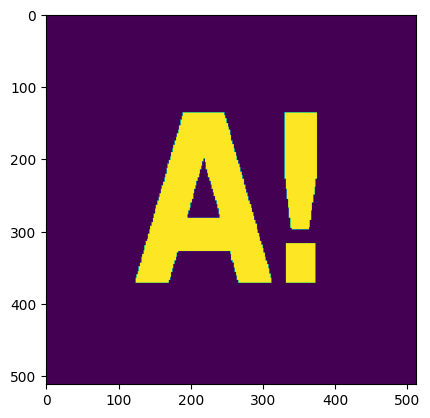

In [3]:
import numpy as np
from PIL import Image
from utils.Helper_Functions import normalize
import matplotlib.pyplot as plt
import torch.nn.functional as F
# choose the recon amp 
im = np.array(Image.open('./Aalto-logo2.png').convert('L'))
target1 = torch.tensor(im, dtype=torch.float).unsqueeze(0).unsqueeze(0)
target1 = normalize(target1)
print(target1.shape)
target1 = F.pad(input=target1, pad=(60, 60, 60, 60), mode='constant', value=0)
target1 = nn.functional.interpolate(torch.round(target1), size=[crop_size, crop_size])
plt.imshow(target1[0,0,:,:])

## 2. Define the System with FullPrecisionDOE

In [7]:
class DOEsystem(nn.Module):
    """ simulate a simple system with one diffractive optical element 
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()

        self.source = PlaneWave(height=input_field_shape[0],
                                width=input_field_shape[1],
                                spacing=input_dxy,
                                wavelengths=wavelengths)

        self.aperture = ApertureElement(aperture_type = 'rect',
                                        aperture_size = input_field_shape[0] * input_dxy / 2)

        self.doe = FullPrecisionDOELayer(doe_params)

        self.asm_prop = ASM_prop(z_distance=0.1 * m, 
                                 bandlimit_type='exact', 
                                 padding_scale=[2, 2], 
                                 bandlimit_kernel=True)

        self.field_crop = Field_Cropper(outputHeight=512,outputWidth=512)

    def forward(self, iter_frac):

        output_field = self.asm_prop(
            self.doe(
                self.aperture(
                    self.source()
                )
            )
        )

        
        return self.field_crop(output_field)

In [8]:
setup = DOEsystem(input_dxy=input_dxy, 
                  input_field_shape=input_field_shape, 
                  doe_params=doe_params, 
                  optim_params=optim_params,
                  wavelengths=wavelength)

In [9]:
max_itrs = 10000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
optimizer = torch.optim.Adam(setup.parameters(), lr=2e-3)

loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(field.data)**2)
    loss = loss_fn(out_amp, target1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_setup = setup
        best_loss = loss
        best_field = field

The critical distance is 198.53894412517548 mm, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.11360812187194824
The iteration : 200, Loss: 0.08599267899990082
The iteration : 400, Loss: 0.0770939365029335
The iteration : 600, Loss: 0.0717131718993187
The iteration : 800, Loss: 0.06773314625024796
The iteration : 1000, Loss: 0.06465688347816467
The iteration : 1200, Loss: 0.06187429651618004
The iteration : 1400, Loss: 0.05961153283715248
The iteration : 1600, Loss: 0.05784837156534195
The iteration : 1800, Loss: 0.05615111440420151
The iteration : 2000, Loss: 0.05440941080451012
The iteration : 2200, Loss: 0.052745625376701355
The iteration : 2400, Loss: 0.05164169520139694
The iteration : 2600, Loss: 0.05020774528384209
The iteration : 2800, Loss: 0.04891221970319748
The iteration : 3000, Loss: 0.04798142611980438
The iteration : 3200, Loss: 0.047033973038196564
The iteration : 3400, Loss: 0.04637383669614792
The iteration : 3600, Loss: 0.04547010362148285
The i

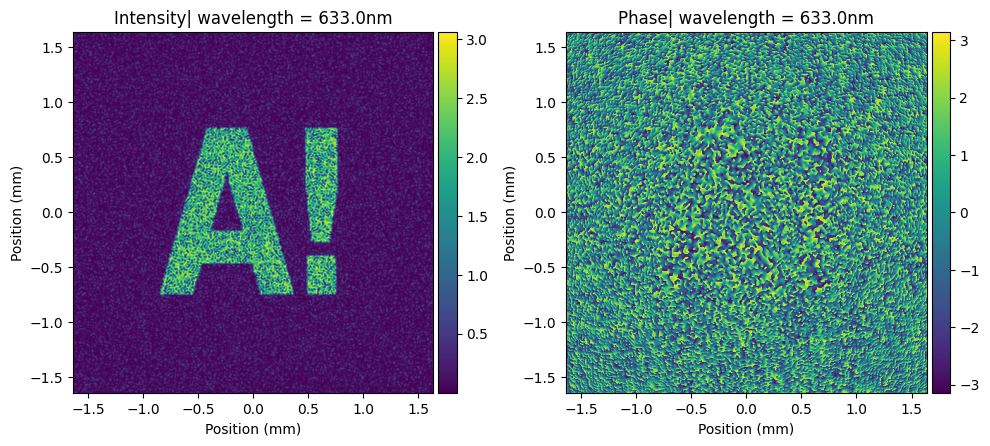

In [10]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelength, intensity=True)

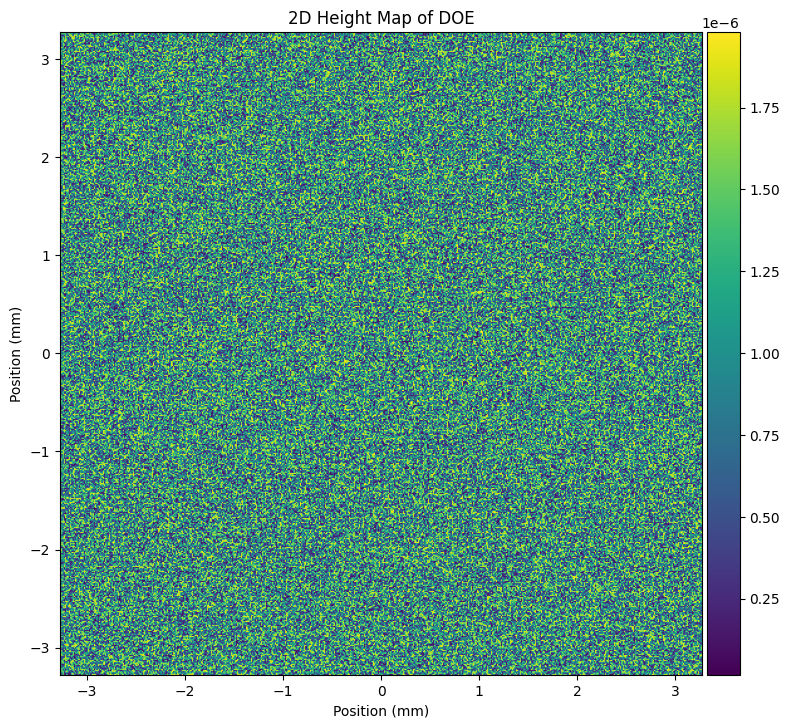

In [11]:
best_setup.doe.visualize(figsize=(8,8), crop_size=[crop_size, crop_size])

## 3. Define the System with Quantized DOE

In [12]:
class DOEsystem(nn.Module):
    """ simulate a simple system with one diffractive optical element 
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()

        self.source = PlaneWave(height=input_field_shape[0],
                                width=input_field_shape[1],
                                spacing=input_dxy,
                                wavelengths=wavelengths)

        self.aperture = ApertureElement(aperture_type = 'rect',
                                        aperture_size = input_field_shape[0] * input_dxy / 2)

        self.doe = SoftGumbelQuantizedDOELayer(doe_params, optim_params)

        self.asm_prop = ASM_prop(z_distance=0.1 * m, 
                                 bandlimit_type='exact', 
                                 padding_scale=[2, 2], 
                                 bandlimit_kernel=True)

        self.field_crop = Field_Cropper(outputHeight=512,outputWidth=512)

    def forward(self, iter_frac):

        output_field = self.asm_prop(
            self.doe(
                self.aperture(
                    self.source()
                )
            , iter_frac)
        )

        
        return self.field_crop(output_field)

In [13]:
setup = DOEsystem(input_dxy=input_dxy, 
                  input_field_shape=input_field_shape, 
                  doe_params=doe_params, 
                  optim_params=optim_params,
                  wavelengths=wavelength)

max_itrs = 10000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=2e-3)

loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(field.data)**2)
    loss = loss_fn(out_amp, target1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_setup = setup
        best_loss = loss
        best_field = field

The critical distance is 198.53894412517548 mm, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.11418886482715607
The iteration : 200, Loss: 0.08309498429298401
The iteration : 400, Loss: 0.07498744130134583
The iteration : 600, Loss: 0.06975497305393219
The iteration : 800, Loss: 0.06572113931179047
The iteration : 1000, Loss: 0.0624375194311142
The iteration : 1200, Loss: 0.05984436720609665
The iteration : 1400, Loss: 0.057571977376937866
The iteration : 1600, Loss: 0.055449165403842926
The iteration : 1800, Loss: 0.0538366362452507
The iteration : 2000, Loss: 0.05239546671509743
The iteration : 2200, Loss: 0.05092696100473404
The iteration : 2400, Loss: 0.049570392817258835
The iteration : 2600, Loss: 0.04825801029801369
The iteration : 2800, Loss: 0.047243259847164154
The iteration : 3000, Loss: 0.04621832072734833
The iteration : 3200, Loss: 0.05272529274225235
The iteration : 3400, Loss: 0.06219048798084259
The iteration : 3600, Loss: 0.07469498366117477
The

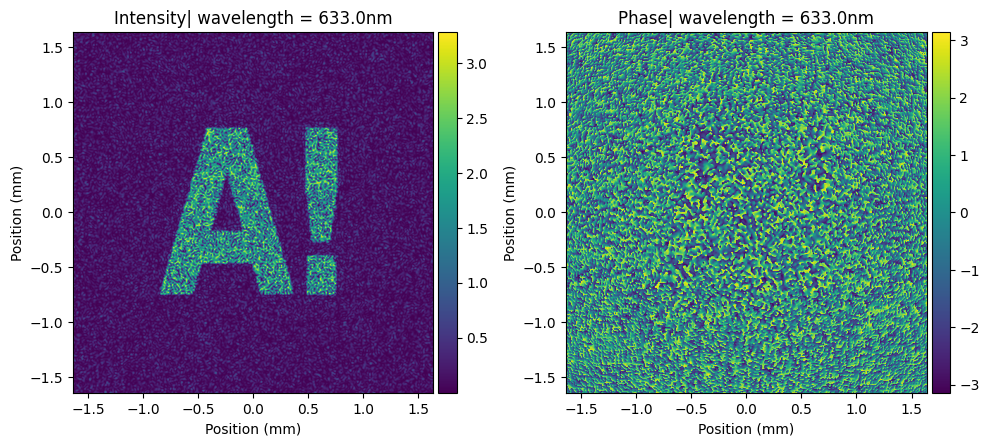

In [14]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelength, intensity=True)

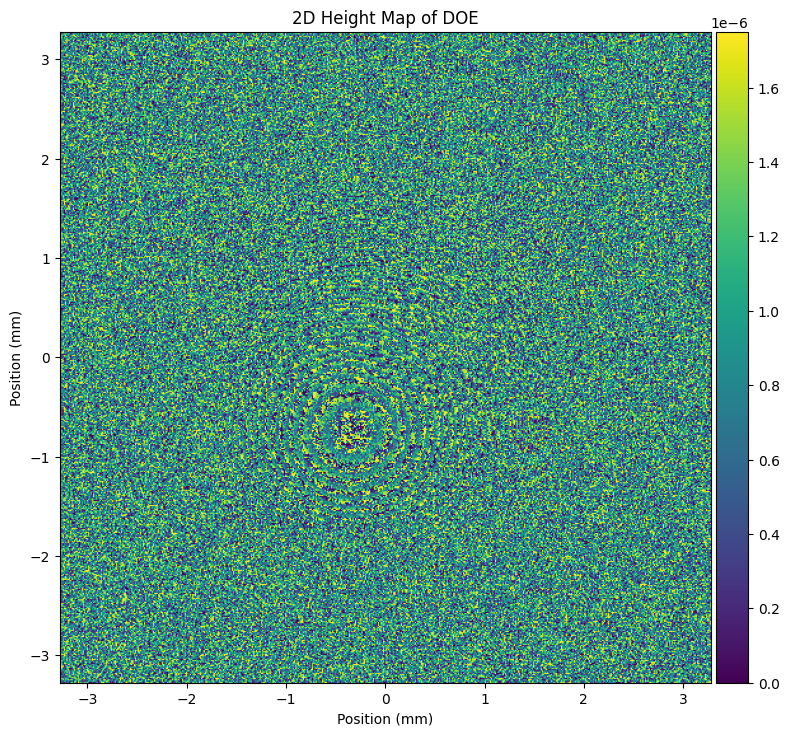

In [15]:
best_setup.doe.visualize(figsize=(8,8), crop_size=[crop_size, crop_size])

In [16]:
best_setup.doe.height_map.unique()

tensor([0.0000e+00, 2.5000e-07, 5.0000e-07, 7.5000e-07, 1.0000e-06, 1.2500e-06,
        1.5000e-06, 1.7500e-06], device='cuda:0', grad_fn=<Unique2Backward0>)